# Load data

In [291]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import geopandas as gpd


import plotly.graph_objs as graphObj
from plotly.offline import plot, iplot
import sys
import adjustText as aT
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [292]:
stateDict = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [293]:
df = pd.read_csv('ECE 143_withPopulation.csv')

df['StateAbbreviation'] = df['State'].map(stateDict)

if 'average_sales' not in df:
    df.insert(5, 'average_sales', df.iloc[:,2:6].mean(axis=1).to_frame())
    df.insert(6,'total_sales',df.iloc[:,2:6].sum(axis = 1).to_frame())
    df['average_sales'] = df['average_sales'].astype(int)
    df['total_sales'] = df['total_sales'].astype(int)
    df['averageSales_Population'] = df['average_sales']/df['Population']
    df['averageSales_TotalSales'] = df['average_sales']/df['total_sales']
    
dfSub = df[['StateAbbreviation','EV Sales\n2018']]

us_states = gpd.read_file("cb_2018_us_state_20m/cb_2018_us_state_20m.shp")
us_states.drop(index = [7,25,48], inplace = True)

In [294]:
df.set_index(["State"], inplace=True)

In [295]:
us_states_plot = pd.merge(us_states,dfSub,left_on='STUSPS',right_on='StateAbbreviation')

In [296]:
us_states_plot["center"] = us_states_plot["geometry"].centroid
us_states_plot_points = us_states_plot.copy()
us_states_plot_points.set_geometry("center", inplace = True)

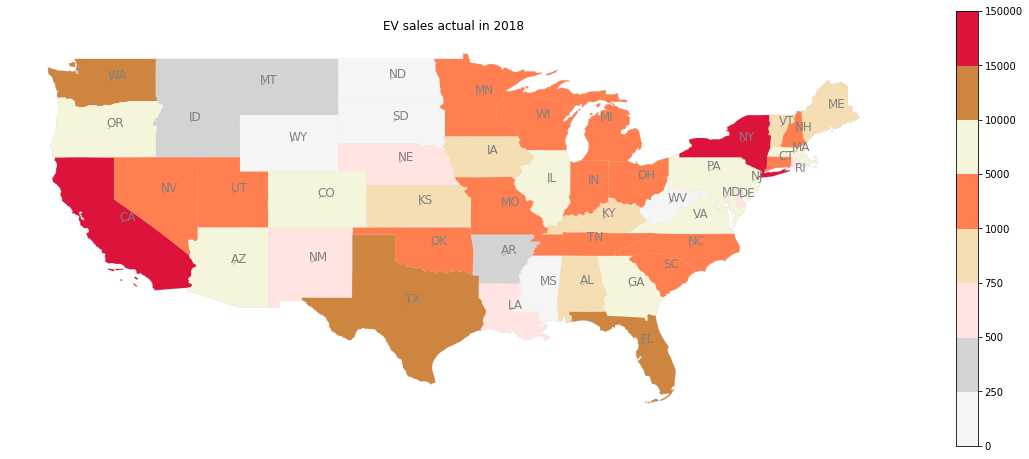

In [297]:
from matplotlib.colors import BoundaryNorm, ListedColormap
cmap = ListedColormap(["whitesmoke", "lightgrey", "mistyrose", "wheat", "coral", "beige", "peru","crimson"])
bounds = [0,250,500,750,1000,5000,10000,15000,150000]
norm = BoundaryNorm(bounds, cmap.N)
texts = []
ax = us_states_plot.geometry.plot(figsize = (20, 16), color = "whitesmoke", edgecolor = "lightgrey", linewidth = 0.5)
for x, y, label in zip(us_states_plot_points.geometry.x, us_states_plot_points.geometry.y, us_states_plot_points["STUSPS"]):
    texts.append(plt.text(x, y, label, color='grey', fontsize = 12))
aT.adjust_text(texts, force_points=0.3, force_text=1, expand_points=(1,1), expand_text=(1,1), 
               arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))
us_states_plot.plot(column = 'EV Sales\n2018', legend_kwds={'shrink': 0.5}, legend=True, ax=ax, cmap=cmap, norm=norm)
ax.axis('off')
ax.set_title("EV sales actual in 2018")
None

In [298]:
sales_2018 = np.array(df[['EV Sales\n2018']])
sales_2015 = np.array(df[['EV Sales\n2015']])
df['percent_Increase_in_sales_2015_2018'] = (sales_2018 - sales_2015)/(sales_2018)

In [299]:
dfPrct = df[["StateAbbreviation","percent_Increase_in_sales_2015_2018"]]

In [300]:
us_states_plot = pd.merge(us_states_plot,dfPrct,on = 'StateAbbreviation')

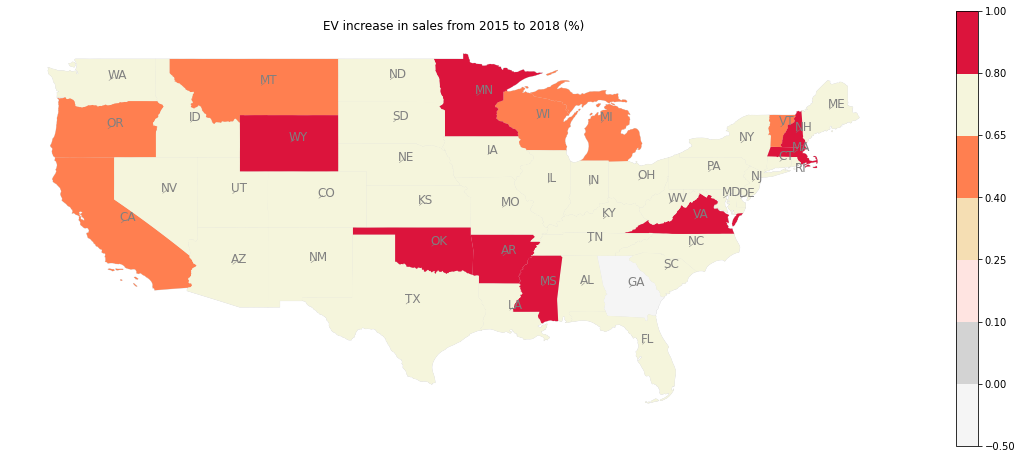

In [302]:
from matplotlib.colors import BoundaryNorm, ListedColormap

cmap = ListedColormap(["whitesmoke", "lightgrey", "mistyrose", "wheat", "coral", "beige","crimson"])
bounds = [-0.5,0,0.1,0.25,0.4,0.65,0.8,1]
norm = BoundaryNorm(bounds, cmap.N)
texts = []
ax = us_states_plot.geometry.plot(figsize = (20, 16), color = "whitesmoke", edgecolor = "lightgrey", linewidth = 0.5)
for x, y, label in zip(us_states_plot_points.geometry.x, us_states_plot_points.geometry.y, us_states_plot_points["STUSPS"]):
    texts.append(plt.text(x, y, label, color='grey', fontsize = 12))
aT.adjust_text(texts,color = 'green', force_points=0.3, force_text=1, expand_points=(1,1), expand_text=(1,1), 
               arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))
us_states_plot.plot(column = 'percent_Increase_in_sales_2015_2018', legend_kwds={'shrink': 0.5}, legend=True, ax=ax, cmap=cmap, norm=norm)
ax.axis('off')
ax.set_title("EV increase in sales from 2015 to 2018 (%)")
None

# Linear regression - Lasso

In [303]:
from sklearn.linear_model import LinearRegression

In [304]:
df.rename(columns={"Avg/C": "Average temperature(Celsius)",
                   "Median Household Income\t $": "Median Household Income", 
                   "% Libertarian/ Independent Representation": "% Libertarian/Independent Representation",
                   "Avg gasoline price per gallon": "Average gasoline price per gallon",
                   "COMMUTE TIME": "Commute time",
                   "PUBLIC TRANSIT USAGE": "Public transit usage",
                   "ROAD QUALITY": "Road quality",
                   "BRIDGE QUALITY": "Bridge quality",
                   "% High school graduate\nor higher": "%High school graduate nor higher",
                   "% Bachelor's degree\nor higher":"%Bachelors degree nor higher"
                   }, inplace=True)

In [306]:
from sklearn.model_selection import train_test_split

X = df.loc[:,['Commute time','Public transit usage','Charging Locations', 'Charging Outlets', 'Democratic Representation',
              'average_sales','averageSales_Population','averageSales_TotalSales']]

Y = df['EV Sales\n2018']
#Y_2018 = df["EV Sales\n2018 % of Total"]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

x = np.array(x_train)
y = np.array(y_train).reshape((len(y_train), 1))

#scaler = preprocessing.StandardScaler()
#scaler.fit(y)
#y = scaler.transform(y)

scaler = preprocessing.StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

scaler = preprocessing.StandardScaler()
scaler.fit(y)
y = scaler.transform(y)

xt = np.array(x_test)


In [307]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
#lrModel = LinearRegression()

clf.fit(x,y)
clf.score(x,y)

0.9811555048419079

In [308]:
clf.coef_

array([ 0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.89556793,  0.        ,  0.        ])

In [309]:
pred = clf.predict(xt)

In [310]:
pred = np.around(pred)

In [311]:
result = pd.DataFrame({ 'true_labels': y_test, 'prediction': pred.astype(int) }) 
result['StateAbbreviation'] = result.index.map(stateDict)
result

,true_labels,prediction,StateAbbreviation
State,,,
New Hampshire,1123,583,NH
Hawaii,2296,1452,HI
Georgia,6004,3961,GA
Michigan,3571,2328,MI
Arizona,7086,3131,AZ
Nevada,2325,1119,NV
Vermont,824,561,VT
New York,15752,7930,NY
Montana,274,143,MT


In [312]:
dfPred = pd.merge(us_states_plot,result,on = "StateAbbreviation")

Prediction on test set

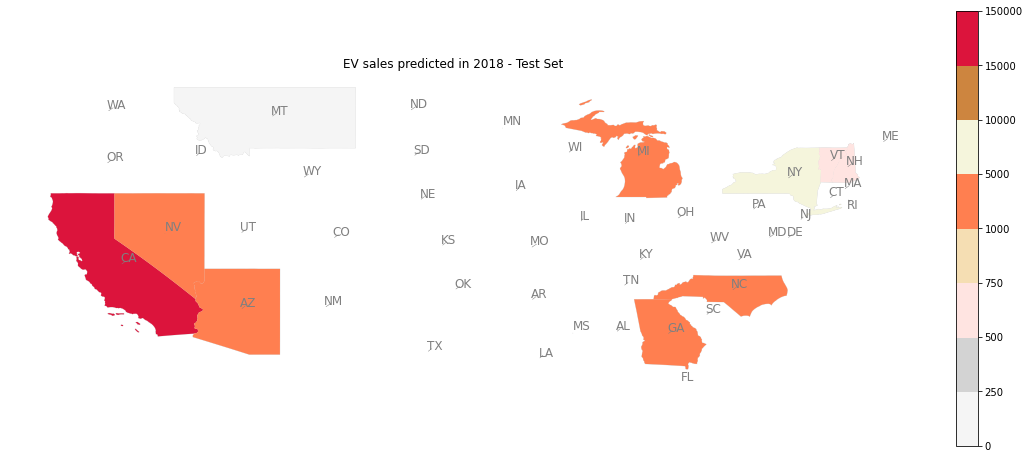

In [315]:
cmap = ListedColormap(["whitesmoke", "lightgrey", "mistyrose", "wheat", "coral", "beige", "peru","crimson"])
bounds = [0,250,500,750,1000,5000,10000,15000,150000]
norm = BoundaryNorm(bounds, cmap.N)
texts = []
ax = dfPred.geometry.plot(figsize = (20, 16), color = "whitesmoke", edgecolor = "lightgrey", linewidth = 0.5)
for x, y, label in zip(us_states_plot_points.geometry.x, us_states_plot_points.geometry.y, us_states_plot_points["STUSPS"]):
    texts.append(plt.text(x, y, label, color='grey', fontsize = 12))
aT.adjust_text(texts, force_points=0.6, force_text=1, expand_points=(1,1), expand_text=(1,1), 
               arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))
dfPred.plot(column = 'prediction', legend_kwds={'shrink': 0.5}, legend=True, ax=ax, cmap=cmap, norm=norm)
ax.axis('off')
ax.set_title("EV sales predicted in 2018 - Test Set")
None

Prediction on all states

In [316]:
xPred = np.array(X)
predForPlot = clf.predict(xPred)

In [317]:
result = pd.DataFrame({ 'true_labels': Y, 'prediction': predForPlot.astype(int)}) 
result.insert(2,'StateAbbreviation',df['StateAbbreviation'])

Model coefficients (equation) - Lasso 

In [318]:
clf.coef_

array([ 0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.89556793,  0.        ,  0.        ])

In [319]:
us_states_predicted = pd.merge(us_states_plot,result,on = "StateAbbreviation")

2018 prediction sales - Model

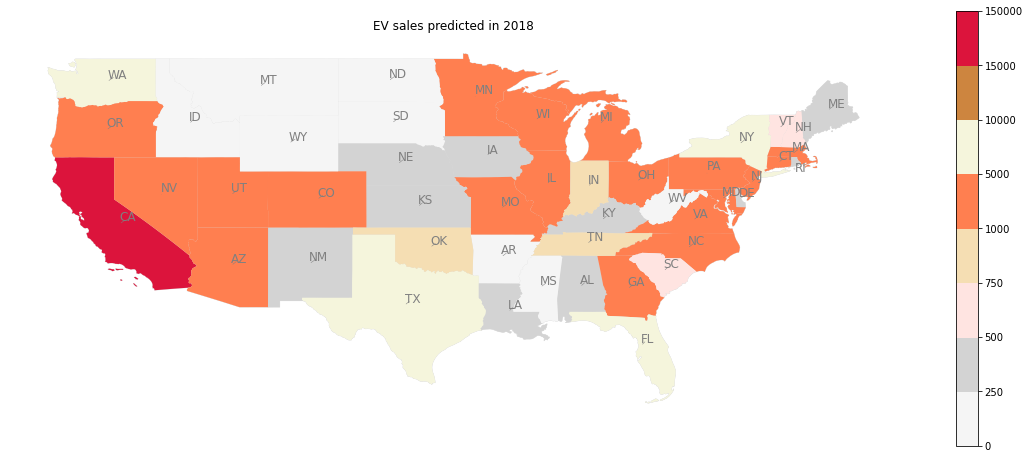

In [320]:
cmap = ListedColormap(["whitesmoke", "lightgrey", "mistyrose", "wheat", "coral", "beige", "peru","crimson"])
bounds = [0,250,500,750,1000,5000,10000,15000,150000]
norm = BoundaryNorm(bounds, cmap.N)
texts = []
ax = us_states_predicted.geometry.plot(figsize = (20, 16), color = "whitesmoke", edgecolor = "lightgrey", linewidth = 0.5)
for x, y, label in zip(us_states_plot_points.geometry.x, us_states_plot_points.geometry.y, us_states_plot_points["STUSPS"]):
    texts.append(plt.text(x, y, label, color='grey', fontsize = 12))
aT.adjust_text(texts, force_points=0.6, force_text=1, expand_points=(1,1), expand_text=(1,1), 
               arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))
us_states_predicted.plot(column = 'prediction', legend_kwds={'shrink': 0.5}, legend=True, ax=ax, cmap=cmap, norm=norm)
ax.axis('off')
ax.set_title("EV sales predicted in 2018")
None